In [1]:
import numpy as np
import matplotlib.pyplot as plt
from label_axes import label_axes
import blip_analysis as ba
import scipy.io as sio
import binary_recording as br
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib
import openephys as oe

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
## Load in all the data
ba.load_usrts()
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

units_usrt1 = np.load('../Data/230704_Fig1_long_usrt1.npy', allow_pickle=True)
units_usrt2 = np.load('../Data/230704_Fig1_long_usrt2.npy', allow_pickle=True)
units_usrt3 = np.load('../Data/230704_Fig1_long_usrt3.npy', allow_pickle=True)
units_usrt1 = units_usrt1[good_indexes]
units_usrt2 = units_usrt2[good_indexes]
units_usrt3 = units_usrt3[good_indexes]

mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt3])

summed_response1 = mean_usrt1[:, :, 50:100].sum(axis=-1)
summed_response2 = mean_usrt2[:, :, 50:100].sum(axis=-1)
summed_response3 = mean_usrt3[:, :, 50:100].sum(axis=-1)




Found odour 1
Found odour 3
Found odour 5


In [3]:
## Indexes for select trials in the full stimulus srt

select_trials = [31, 30, 28, 24, 16, 8, 4, 2, 1, 0]
conc_trials = [31, 30, 28, 24, 16]
onset_trials = [1, 2, 4, 8, 16]
iti_trials = [24, 20, 18, 17]

In [4]:
## Find trials which respond later on during the onset trials

sorted_args = np.argsort(np.argmax(mean_usrt1[:, onset_trials[-1]], axis=-1))

/home/camp/warnert/neurolytics/binary_recording.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


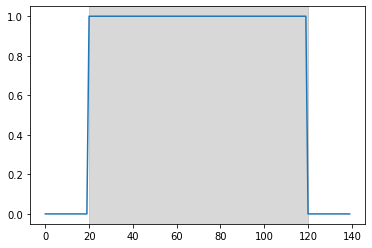

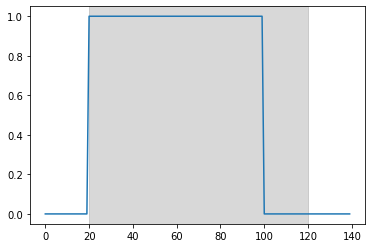

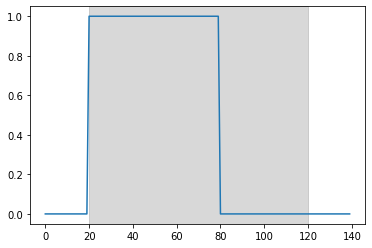

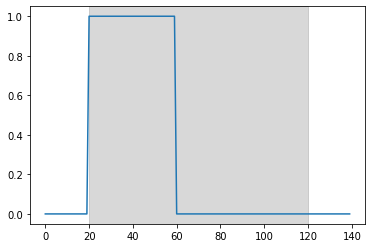

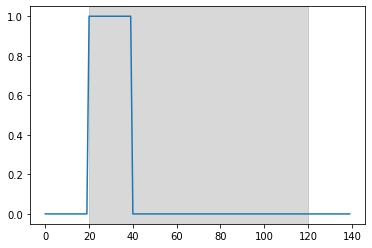

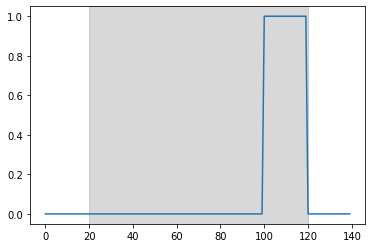

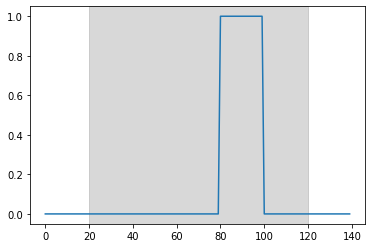

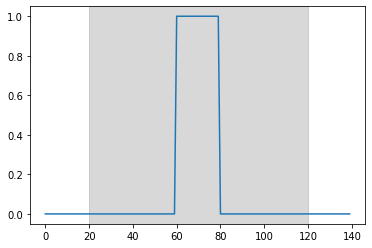

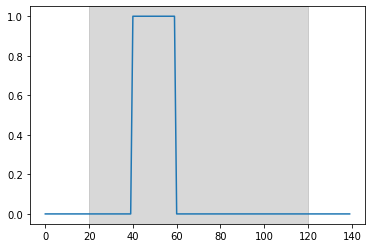

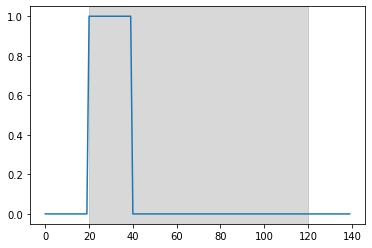

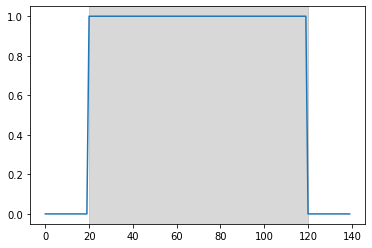

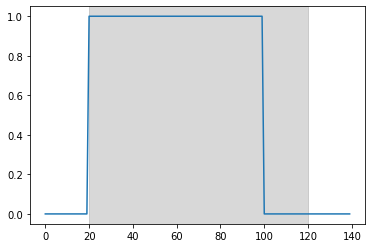

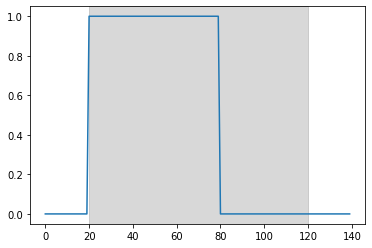

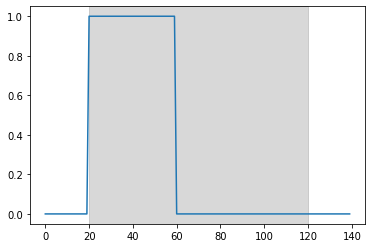

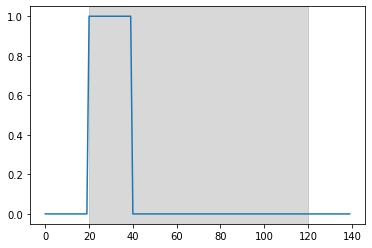

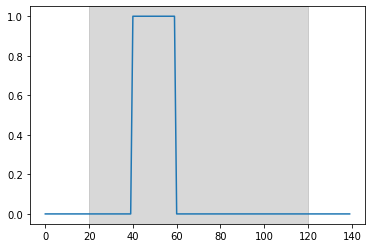

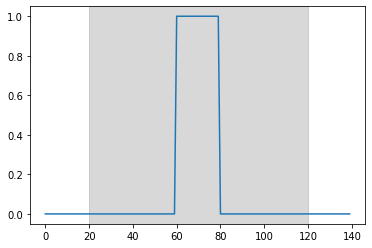

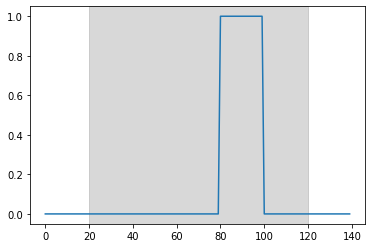

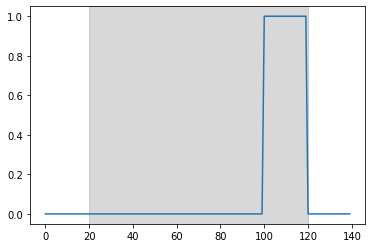

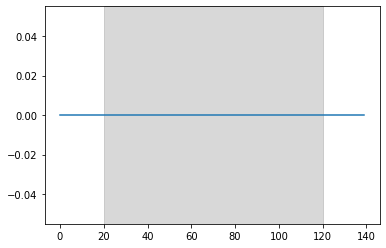

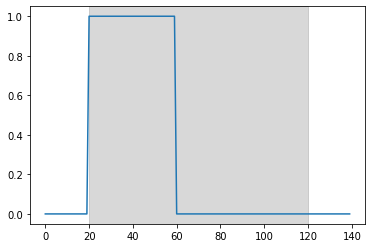

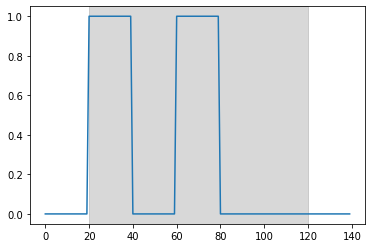

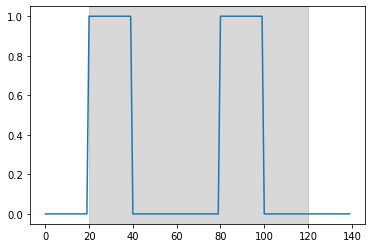

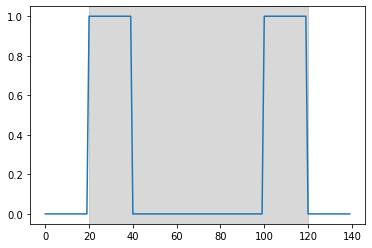

In [5]:
### Generate the plots for the stimuli - I never got round to preventing
### the plots from being generated, but we need the data for the figure
plots_conc = [br.binary_plotter(i) for i in conc_trials]
plots_onset = [br.binary_plotter(i) for i in onset_trials]
plots_all = [br.binary_plotter(i) for i in select_trials]
plots_iti = [br.binary_plotter(i) for i in iti_trials]

In [6]:
## Generate the linkage for the hierarchical clustering

link = linkage(summed_response1/np.max(summed_response1, axis=-1)[:, np.newaxis], optimal_ordering=True, method='complete', )
dend = dendrogram(link, no_plot=True)
leaves = dend['leaves']

In [7]:
### Getting the PID and flow recording - I know its unweildy but the data
### is in a weird format
odour_path = "../Data/"


EB_trials = open(odour_path + '2020-06-15trial_name_flowmeter_EB_2.txt', 'r').readlines()
trial_order = []
for i in EB_trials:
    if ':' not in i:
        trial_order.append(i.split('_')[1][:-1])
EB_flows = sio.loadmat(odour_path+'Flowmeter_EB_pulses_3.mat')
print(EB_flows.keys())
trig = EB_flows['Flowmeter_EB_pulses_3_Ch8'][-1][-1][-1]
EB_flowmeter = EB_flows['Flowmeter_EB_pulses_3_Ch7'][-1][-1][-1]
print(EB_flows.keys())

EB_PIDs = sio.loadmat(odour_path+'PID_all_pulses_PID.mat')

PID = EB_PIDs['PID_all_pulses_PID_Ch6'][-1][-1][-1]
PID_trig = EB_PIDs['PID_all_pulses_PID_Ch8'][-1][-1][-1]

PID_trials = open(odour_path+'2020-06-15trial_name.txt', 'r').readlines()
PID_order = []
for i in PID_trials:
    if ':' not in i:
        PID_order.append(i.split('_')[1][:-1])
        

IA_flows = sio.loadmat(odour_path+'Flowmeter_IA_pulses.mat')
trig_IA = IA_flows['Flowmeter_IA_pulses_Ch8'][-1][-1][-1]
flowmeter_IA = IA_flows['Flowmeter_IA_pulses_Ch7'][-1][-1][-1]

IA_trials = open(odour_path+'2020-06-15trial_name_flowmeter_IA.txt')
IA_order = []

for i in IA_trials:
    if ':' not in i:
        IA_order.append(i.split('_')[1][:-1])
        
prev_start = 0
EB_flow_starts = []
for index, i in enumerate(trig):
    if i > 1 and index - prev_start > 10000:
        EB_flow_starts.append(index)
        prev_start = index

        
PID_starts = []
prev_start = 0
for index, i in enumerate(PID_trig):
    if i > .5 and index - prev_start > 10000:
        PID_starts.append(index)
        prev_start = index
print(len(PID_starts)/32)

IA_starts = []
prev_start = 0
for index, i in enumerate(trig_IA):
    if i > 1 and index - prev_start > 10000:
        IA_starts.append(index)
        prev_start = index
        
trial_order = np.array(trial_order)
PID_order = np.array(PID_order)
EB_flow_starts = np.array(EB_flow_starts)
PID_starts = np.array(PID_starts)
IA_starts = np.array(IA_starts)
IA_order = np.array(IA_order)
fs = 10000
pre_window=0.5
post_window=0.62
#trial_order.astype(np.int)
all_trial_flows = []
all_trials_PID = []
all_trials_IA = []
for i in range(32):
    trial_starts = EB_flow_starts[(trial_order == str(i))]
    trial_flows = [EB_flowmeter[int(j-fs*pre_window):int(j+fs*post_window)] for j in trial_starts]
    all_trial_flows.append(trial_flows)
    PID_trials = PID_starts[(PID_order == str(i))]
    trial_PIDs = [PID[int(j-fs*pre_window):int(j+fs*post_window)] for j in PID_trials]
    all_trials_PID.append(trial_PIDs)
    
    trials_IA = IA_starts[(IA_order == str(i))]
    trial_IAs = [flowmeter_IA[int(j - fs*pre_window):int(j+fs*post_window)] for j in trials_IA]
    all_trials_IA.append(trial_IAs)
mean_trial_flows = np.mean(all_trial_flows, axis=1)
mean_trial_PIDs = np.mean(all_trials_PID, axis=1)
mean_trial_IA = np.mean(all_trials_IA, axis=1)

dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
5.0


In [8]:
### More PID and flow data

mats = sio.loadmat(odour_path + '200618_EB_IA_5_reps_altered_duties.mat')
print(mats.keys())
trigs = mats['V200618_EB_IA_5_reps_altered_duties_Ch8'][-1][-1][-1]
flows = mats['V200618_EB_IA_5_reps_altered_duties_Ch7'][-1][-1][-1]

prev_start = 0 
flow_starts = []
for index, i in enumerate(trigs):
    if i > 1 and index - prev_start > 10000:
        flow_starts.append(index)
        prev_start = index
        
all_flows = []
for i in range(64):
    reps = flow_starts[i::64]
    flow_reps = [flows[j-2000:j+5000] for j in reps]
    all_flows.append(flow_reps)

dict_keys(['__header__', '__version__', '__globals__', 'V200618_EB_IA_5_reps_altered_duties_Ch1', 'V200618_EB_IA_5_reps_altered_duties_Ch2', 'V200618_EB_IA_5_reps_altered_duties_Ch3', 'V200618_EB_IA_5_reps_altered_duties_Ch4', 'V200618_EB_IA_5_reps_altered_duties_Ch5', 'V200618_EB_IA_5_reps_altered_duties_Ch6', 'V200618_EB_IA_5_reps_altered_duties_Ch7', 'V200618_EB_IA_5_reps_altered_duties_Ch8', 'V200618_EB_IA_5_reps_altered_duties_Ch31'])


In [9]:
### Load in an example respiration trace
ti = 1500
resp = oe.loadContinuous2('../Data/100_ADC1.continuous')
ts = np.load('../Data/230704_fig1_trial_start.npy')
sos = scipy.signal.butter(3, 100, 'low', fs=30000, output='sos')
filtered = scipy.signal.sosfilt(sos, resp['data'][int(ts[ti]-30000):int(ts[ti]+30000*0.62)])
filtered = filtered[15000:] - np.median(filtered)
filtered = -filtered


In [10]:
### Plotting functions

def plot_pid_and_flow(trial_num, ax, legend=False, y_axis=False, bb_legend=None):
    '''
    Plotting function for PID and flow data - used in C

    '''

    xs = np.arange(-.2, .5, 1/10000)
    for i in all_flows[trial_num]:
        ax.plot(xs, i, color='skyblue', alpha=0.4)
    ax.plot(xs, np.mean(all_flows, axis=1)[trial_num], label='Flow')
    #ax.set_ylabel('Flowmeter voltage')
    ax2 = ax.twinx()
    ax2.plot([], label='Flow')
    for i in all_trials_PID[trial_num]:
        ax2.plot(xs, i[3070:10070], alpha=0.4, color='coral')
    ax2.plot(xs, mean_trial_PIDs[trial_num][3070:10070],  label='PID',color='C1')
    ax2.set_ylim(.1, 2)
    #ax2.set_ylabel('PID volatage')
    if legend:
        plt.legend(ncol=2, bbox_to_anchor=bb_legend)
    #ax.set_xlabel('Time (s)')
    #ax.set_title('EB_%d/%s' % (trial_num, str(bin(trial_num)[2:])))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    if y_axis:
        ax.set_ylabel('Flow (V)', color='C0')
        ax2.set_ylabel('Odour concentration (V)', color='C1')
    return ax

def plot_onset_and_conc(mean_resp, onset_ax, conc_ax):
    ''' 
    Plotting function for onset and concentration data - used in Di
    '''
    xs = np.arange(-.5, .62, 1/100)[:-1]

    conc_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    conc_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    for index, i in enumerate(conc_trials[:-1]):
        conc_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr((index+1)/len(conc_trials)/2))

    conc_ax.axvspan(0, 0.1, color='yellow', alpha=0.5)
    onset_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    for index2, i in enumerate(onset_trials[::-1]):
        onset_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr(.5 + (index2)/len(plots_conc)/2))
    onset_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    onset_ax.axvspan(0, 0.1, color='yellow', alpha=0.5, zorder=-100)
    onset_ax.set_xticklabels([])



def plot_psth(fig, gs, usrt, selected_trials, ui, xs, cmap='winter', linethickness=1, add_resp=False, add_axvspan=False):
    '''
    Plotting function used to generate the PSTHs in D
    '''
    mean_usrt = [np.mean(i, axis=0) for i in usrt[ui]]
    std_usrt = [np.std(i, axis=0) for i in usrt[ui]]
    if add_resp:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=11, hspace=.1)
        ax1 = fig.add_subplot(sub_gridspec[1:6])
        ax2 = fig.add_subplot(sub_gridspec[6:11])
        resp_ax = fig.add_subplot(sub_gridspec[0])
        resp_xs = np.arange(-.5, .62, 1/30000)
        resp_ax.plot(resp_xs, filtered, 'k')
        resp_ax.set_xticks([])
        resp_ax.spines['right'].set_visible(False)
        resp_ax.spines['top'].set_visible(False)
        resp_ax.spines['bottom'].set_visible(False)
        resp_ax.spines['left'].set_visible(False)
        resp_ax.set_yticks([])
        #resp_ax.axvspan(0, 0.1, color='lightgray')
    else:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=2, hspace=.1)

        ax1 = fig.add_subplot(sub_gridspec[0])
        ax2 = fig.add_subplot(sub_gridspec[1])
    selected_trials = selected_trials[::-1]

    count = 0
    ax1.plot(xs, mean_usrt[0], color='k', linestyle='--', linewidth=linethickness)
    ax2.plot(xs, mean_usrt[0], color='k', linestyle='--', linewidth=linethickness)
    for index, i in enumerate(selected_trials[1:6]):
        ax1.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)(index/(len(selected_trials)-1)), linewidth=linethickness)
        count += 1
    count -= 1
    for index, i in enumerate(selected_trials[5:]):
        ax2.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)((index+count)/(len(selected_trials)-1)), linewidth=linethickness)
    
    ax1_lims = ax1.get_ylim()
    ax2_lims = ax2.get_ylim()
    ylim_max = np.max([ax1_lims, ax2_lims])
    ylim_min = np.min([ax1_lims, ax2_lims])
    ylim = [ylim_min, ylim_max]
    #ax1.axvspan(0, 0.1, color='lightgray')
    #ax2.axvspan(0, 0.1, color='lightgray')
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xticklabels([])
    x1, x2 = 0.0, 0.1
    y0= ax2.get_ylim()[0]
    disp_coords = ax2.transData.transform([(x1, y0), (x2, y0)])
    fig_coords = fig.transFigure.inverted().transform(disp_coords)
    axs = [ax1, ax2]
    if add_resp:
        resp_ax.set_xlim(ax1.get_xlim())
        axs.append(resp_ax)
    if add_axvspan:
        lower_left = fig_coords[0]
        width = fig_coords[1][0] - fig_coords[0][0]
        height = [i.get_position().height for i in axs]
        height = np.sum(height)*1.1
        rect = matplotlib.patches.Rectangle(lower_left, width=width, height=height, transform=fig.transFigure,
                         facecolor='gray', alpha=0.5)
        fig.patches.extend([rect])
    return axs

In [11]:
### More plotting functions

def dendo_and_heatmaps(fig, gs, link, summed_response, norm_choice='max', zscore_params=None, flip = True, **kwargs):
    '''
    Plots both parts E and F of the figure
    '''
    colors = ['k' for i in range(300)]
    sub_gridspec = gs.subgridspec(1, 2, wspace=0.3)
    if flip:
        sub_sub_gridspec = sub_gridspec[1].subgridspec(1, 2, wspace=0.0)
    else:
        sub_sub_gridspec = sub_gridspec[0].subgridspec(1, 2, wspace=0.0)
    
    dend_ax = fig.add_subplot(sub_sub_gridspec[0])
    dend = dendrogram(link, ax=dend_ax, orientation='left', truncate_mode=None, no_labels=True, color_threshold=0.1, link_color_func=lambda k: colors[k])
    dend_ax.set_ylabel('Units', labelpad=-5)
    #dend_ax.set_xlabel('Distance')
    dend_ax.set_xticks([])
    norm_heatmap_ax = fig.add_subplot(sub_sub_gridspec[1])
    if norm_choice == 'max':
        normed_response = summed_response/np.max(summed_response, axis=-1)[:, np.newaxis]
    elif norm_choice == 'zscore_base':
        assert zscore_params is not None, 'Please pass zscore_params'
        normed_response = (summed_response - zscore_params[0])/zscore_params[1]
    
    im = norm_heatmap_ax.imshow(normed_response[dend['leaves'][::-1]], cmap='pink', aspect='auto')
#     plt.colorbar(mappable=im, ax=norm_heatmap_ax, aspect=40)
    norm_heatmap_ax.set_xticks(range(32))
    norm_heatmap_ax.set_xticklabels(glyphs, rotation=90, fontsize=5);
    norm_heatmap_ax.set_yticks([])
    divider = make_axes_locatable(norm_heatmap_ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    dend_ax.spines['top'].set_visible(False)
    dend_ax.spines['left'].set_visible(False)
    dend_ax.spines['bottom'].set_visible(False)
    
    #resp_heatmap_ax = fig.add_subplot(sub_gridspec[1])
    if flip:
        sub_sub_gridspec = sub_gridspec[0].subgridspec(1, 2, wspace=0.15)
    else:
        sub_sub_gridspec = sub_gridspec[1].subgridspec(1, 2, wspace=0.15)
    resp_heatmap_ax1 = fig.add_subplot(sub_sub_gridspec[0])
    resp_heatmap_ax2 = fig.add_subplot(sub_sub_gridspec[1])
    #plt.colorbar(im, cax=cax)
#    heatmap_cbar_ax = fig.add_subplot(sub_gridspec[39])
    #plot_heatmap(resp_heatmap_ax1, mean_usrt1, select_trials, dend['leaves'][::-1], **kwargs)
    vmax = np.max(mean_usrt1[:, select_trials])
    plot_heatmap(resp_heatmap_ax1, mean_usrt1, conc_trials, dend['leaves'][::-1], colorbar=False, vmax=vmax, cmap='Reds', **kwargs)
    pos = plot_heatmap(resp_heatmap_ax2, mean_usrt1, onset_trials, dend['leaves'][::-1], vmax=vmax, cmap='Blues', **kwargs)
    normed_pos = norm_heatmap_ax.get_position()
    cax_pos = [normed_pos.x0+normed_pos.width+0.01, normed_pos.y0+normed_pos.height*(1-0.8)/2, 0.02, normed_pos.height*0.8]
    cax = fig.add_axes(cax_pos)
    plt.colorbar(im, cax=cax)
    resp_heatmap_ax2.set_yticklabels([])
    resp_heatmap_ax2.set_ylabel('')
 #   normed_cbar_ax = fig.add_subplot(sub_gridspec[37])
#    plt.colorbar(mappable=im, cax=normed_cbar_ax)
    return dend_ax, resp_heatmap_ax1, resp_heatmap_ax2, dend['leaves'][::-1]

def plot_heatmap(ax, mean_usrt, select_trials, sorted_args=None, time_offset=25, cmap='binary', 
                 time_ticks_base = None, colorbar_ax=None, colorbar=True, vmax=None, normalise_rows=False,
                 log=False):  
    '''
    Plot a heatmap, used in E and F
    '''
    if sorted_args is None:
        sorted_args = np.argsort(np.argmax(mean_usrt[:, select_trials[::-1][-1]], axis=-1))
    unit_count = len(mean_usrt)
    joined_psths = mean_usrt[sorted_args][:, select_trials[::-1], time_offset:].reshape(unit_count, -1)
    if normalise_rows:
        joined_psths = joined_psths/np.max(joined_psths, axis=-1)[:, np.newaxis]
    if log:
        joined_psths = np.log10(joined_psths)
    im = ax.imshow(joined_psths, cmap=cmap, aspect='auto', vmax=vmax, vmin=0)
    ax.axvspan(50-time_offset, 50-time_offset+10, color='y', alpha=0.2)
    time_len = mean_usrt.shape[-1] - time_offset
    if time_ticks_base is None:
        pre_window = time_offset/100 - .5
        post_window = time_len/100 + pre_window
        
        time_ticks_base = np.arange(pre_window, post_window, -1*pre_window)
    
    full_xs = np.arange(time_offset/100-.5, time_len/100, 1/100).round(2)
    #print(full_xs.round(2))
    xticks_base = np.array([np.where(full_xs == i)[0][0] for i in time_ticks_base])
    
 #   xticks_base = np.linspace(0, time_len, int(pre_window*-100))
    #print(xticks_base)
    time_ticks = []
    xticks = []
    for i in range(len(select_trials)):
        xticks.append(xticks_base+i*time_len)
        time_ticks.append(time_ticks_base)

    ax.set_xticks(np.concatenate(xticks))
    
    ax.set_xticklabels(np.concatenate(time_ticks), rotation=90)
    for i in range(1, len(select_trials)):
        ax.axvline(87*i, color='k')
        ax.axvspan(25+87*i, 35+87*i, color='y', alpha=0.2)
        ax.text(17+87*i, -2, glyphs[select_trials[::-1][i]], fontsize=7)

    ax.text(17, -2, glyphs[select_trials[-1]], fontsize=7)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Units')
    if colorbar:
        if colorbar_ax is None:
            #divider = make_axes_locatable(ax)
            # cax = divider.append_axes('right', size='5%', pad=0.05)
            pos = ax.get_position()
            pos = [pos.x0+pos.width+0.01, pos.y0+pos.height*(1-0.8)/2, 0.02, pos.height*0.8]
            cax = fig.add_axes(pos)
            plt.colorbar(mappable=im, cax=cax)
            cax.set_ylabel('Firing rate (Hz)')
        else:
            plt.colorbar(mappable=im, cax=colorbar_ax)
    
    plt.draw()
    if colorbar:
        if colorbar_ax is None:
            return cax


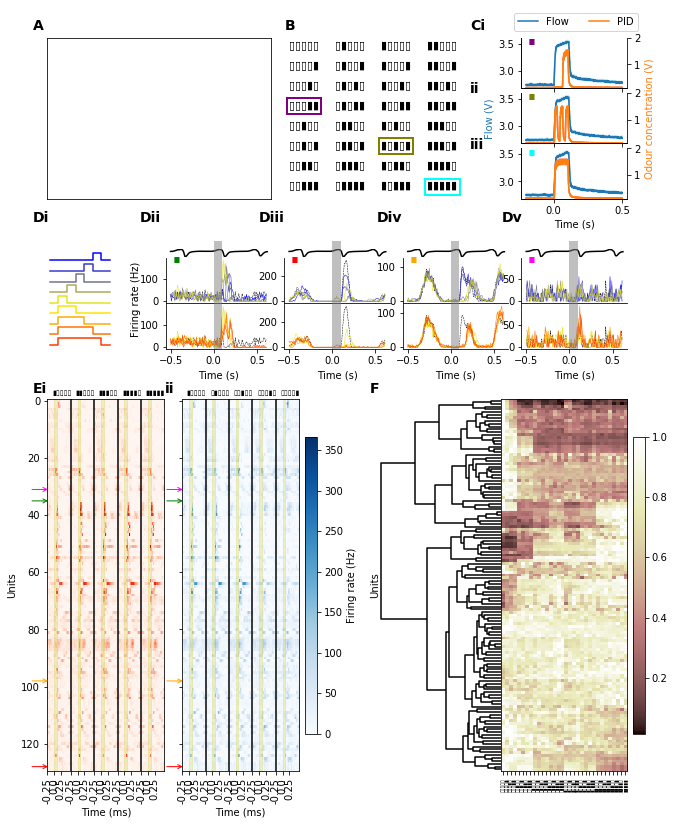

In [12]:
### Fig 1 plotting
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue", 'yellow','red'])
fig = plt.figure(figsize=(8.3, 11.7))
gs = matplotlib.gridspec.GridSpec(25, 15,wspace=.5, hspace=2, left=0.0, right=0.97, bottom=0.1, top=0.97)

odour_colors = ['purple', 'olive', 'cyan']
odour_indexes = [3, 21, 31]

### Make A
mouse_ax = fig.add_subplot(gs[:6, :6])
mouse_ax.set_xticks([])
mouse_ax.set_yticks([])

### Make part B
blip_ax = fig.add_subplot(gs[:6, 6:11])
for i in range(32):
    blip_ax.text(int(i/8)+0.1, 8-i%8-0.5, glyphs[i], fontsize=11)
    if i in odour_indexes:
        color = odour_colors[odour_indexes.index(i)]
        blip_ax.plot([int(i/8)+0.05, int(i/8)+0.05], [8-i%8-0.8, 8-i%8], color, linewidth=2)
        blip_ax.plot([int(i/8)+0.8, int(i/8)+0.8], [8-i%8-0.8, 8-i%8], color, linewidth=2)
        blip_ax.plot([int(i/8)+0.05, int(i/8)+0.8], [8-i%8-0.8, 8-i%8-0.8], color, linewidth=2)
        blip_ax.plot([int(i/8)+0.05, int(i/8)+0.8], [8-i%8, 8-i%8], color, linewidth=2)
blip_ax.set_xlim(0, 4)
blip_ax.set_ylim(0, 8)
blip_ax.axis('off')

### Make part C
odour_axes = gs[:6, 12:15].subgridspec(ncols=1, nrows=3, hspace=0.1)

odour_ax1 = fig.add_subplot(odour_axes[0])
odour_ax2 = fig.add_subplot(odour_axes[1], sharex=odour_ax1, sharey=odour_ax1)
odour_ax3 = fig.add_subplot(odour_axes[2], sharex=odour_ax1, sharey=odour_ax1)

plt.setp(odour_ax1.get_xticklabels(), visible=False)
plt.setp(odour_ax2.get_xticklabels(), visible=False)

odour_ax1 = plot_pid_and_flow(3, odour_ax1, legend=True, bb_legend=(1.15, 1.6))
odour_ax2 = plot_pid_and_flow(21, odour_ax2, y_axis=True)
odour_ax3 = plot_pid_and_flow(31, odour_ax3)
odour_ax3.set_xlabel('Time (s)')

xs = np.arange(-.5, .62, 1/100)[:-1]

### Make part D

# Cells selected for part D
select_cells = [sorted_args[-38], 42, sorted_args[99], sorted_args[5]]
select_cells = [35, 128, 98, 31]

stimuli_ax = fig.add_subplot(gs[7:11, :2])

for index, i in enumerate(plots_all[:-1][::-1]):
    stimuli_ax.step(range(len(i)), i-index*1.5, color=cmap(index/(len(plots_all)-1)))
    
stimuli_ax.axis('off')
stimuli_ax.set_xlabel('Time')

# Colors used for arrows in part E and to connect D and E
colors = ['green', 'red', 'orange', 'magenta']

cax11, cax12, resp_ax1 = plot_psth(fig, gs[7:11, 3:6], units_usrt1, select_trials, leaves[select_cells[0]], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)
cax21, cax22, resp_ax2 = plot_psth(fig, gs[7:11, 6:9], units_usrt1, select_trials, leaves[select_cells[1]], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)
cax31, cax32, resp_ax3 = plot_psth(fig, gs[7:11, 9:12], units_usrt1, select_trials, leaves[select_cells[2]], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)
cax41, cax42, resp_ax4 = plot_psth(fig, gs[7:11, 12:15], units_usrt1, select_trials, leaves[select_cells[3]], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)
[i.set_xlabel('Time (s)') for i in [cax12, cax22, cax32, cax42]]

# A big axes for the labels
label_ax = fig.add_subplot(gs[7:11, 3:6], frameon=False)
label_ax.set_xticks([])
label_ax.set_yticks([])
label_ax.set_ylabel('Firing rate (Hz)', labelpad=25)

### Make part E
dend_ax, heatmap_ax1, heatmap_ax2, leaves = dendo_and_heatmaps(fig, gs[12:25, :], link, summed_response1, time_ticks_base=[-0.25, 0.0, 0.25])

### Some finishing touches
axes = [mouse_ax, blip_ax, odour_ax1, odour_ax2, odour_ax3, stimuli_ax,  cax11, cax21, cax31, cax41, heatmap_ax1, heatmap_ax2, dend_ax]

# Adds the arrows to the heatmaps
for i in select_cells:
    heatmap_ax1.annotate('', xy=(10, i), xycoords='data',
            xytext=(-20, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color=colors[select_cells.index(i)]))
    heatmap_ax2.annotate('', xy=(10, i), xycoords='data',
            xytext=(-20, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color=colors[select_cells.index(i)]))
for index, ax in enumerate([cax11, cax21, cax31, cax41]):
    ax.annotate('.', xy=(0.1, 0.6), xycoords='axes fraction', xytext=(0, 3),
            textcoords='offset points', ha='center',
            va='bottom', fontsize=50, color=colors[index])


labels = ['A', 'B', 'Ci', 'ii', 'iii', 'Di', 'Dii', 'Diii', 'Div', 'Dv', 'Ei', 'ii', 'F']
dy = [0.01, 0.01, 0.01, 0, 0, 0.01, 0.01, 0.01, 0.01, 0.01, 0, 0, 0]
dx = [0, 0, -0.04, -0.04, -0.04, 0, 0, 0, 0, 0, 0, 0, 0]
label_axes.label_axes(axes, labels, align_y=[[0, 1, 2], [5, 6, 7, 8, 9], [10, 11, 12]], align_x=[[0, 5, 10], [2, 3, 4]], dy=dy, dx=dx, fontsize=14, fontweight='bold')

# Adds squares to the response traces
for index, ax in enumerate([odour_ax1, odour_ax2, odour_ax3]):
    ax.annotate('.', xy=(0.1, 0.6), xycoords='axes fraction', xytext=(0, 3),
            textcoords='offset points', ha='center',
            va='bottom', fontsize=50, color=odour_colors[index])
#plt.savefig('230630_fig1.pdf', bbox_inches='tight')

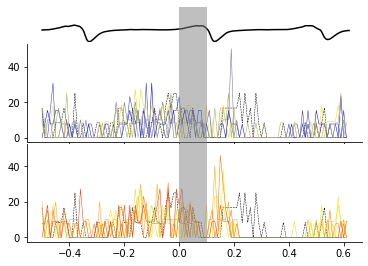

In [13]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(1, 1)
cax11, cax12, resp_ax1 = plot_psth(fig, gs[0], units_usrt1, select_trials, leaves[select_cells[0]], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)


In [14]:
ui +=1
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in iti_trials:
    ax[0].plot(mean_usrt1[ui, i])
    ax[1].plot(mean_usrt2[ui, i])
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# for i in iti_trials:
#     ax[0].plot(mean_usrt1[ui, i])
#     ax[1].plot(mean_usrt2[ui, i])
print(ui)

NameError: name 'ui' is not defined

In [23]:
conc_uis = [18, 24, 25, 26, 27, 28, 37, 50, 54, 55, 59, 60, 62, 63, 70, 122, 123]
onset_uis = [18, 20, 21, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 39, 40, 46, 48, 51, 54, 59,60, 62, 81, 85, 86, 88, 91, 93, 95, 98, 99, 109, 121, 123, 125, 126]
iti_uis = [29, 36, 37, 54, 59, 60, 62, 81, 90, 91, 98, 123, 125]

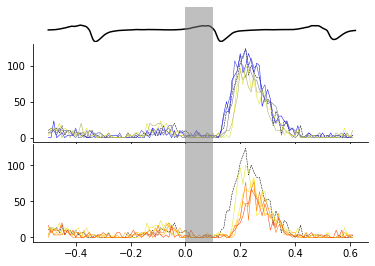

In [14]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(1, 1)
cax11, cax12, resp_ax1 = plot_psth(fig, gs[0], units_usrt1, select_trials, onset_uis[0], xs, cmap=cmap, linethickness=0.5, add_axvspan=True, add_resp=True)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc85ca65d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc85ca9f2b0>)

<Figure size 504x216 with 0 Axes>

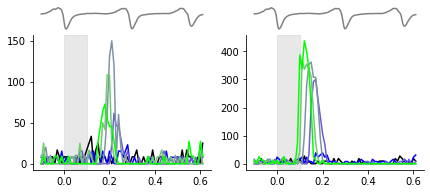

In [24]:
fig = plt.figure(figsize=(7, 3))


def plot_cell_psth(mean_usrt, ui, select_trials, gs, cmap, start = 40, end = 112, xticklabels=True):
    sub_gs = gs.subgridspec(6, 1)
    ax = fig.add_subplot(sub_gs[1:, 0])
    resp_ax = fig.add_subplot(sub_gs[0, 0])
    resp_xs = np.arange(-.5, .62, 1/30000)
    psth_xs = np.arange(-.5, .62, 1/100)[start:end]
    resp_ax.plot(resp_xs, filtered, 'gray')
    resp_ax.set_xticks([])
    resp_ax.spines['right'].set_visible(False)
    resp_ax.spines['top'].set_visible(False)
    resp_ax.spines['bottom'].set_visible(False)
    resp_ax.spines['left'].set_visible(False)
    resp_ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot(psth_xs, mean_usrt[ui, 0, start:end], color='k')
    for index, i in enumerate(select_trials):
        ax.plot(psth_xs, mean_usrt[ui, i, start:end], color=matplotlib.cm.get_cmap(cmap)(index/(len(select_trials)-1)))
    ax.axvspan(0, 0.1, alpha=0.5, color='lightgrey')
    if not xticklabels:
        ax.set_xticklabels([])
    return ax, resp_ax
    
    

fig = plt.figure(figsize=(7, 3))
gs = fig.add_gridspec(1, 2)
ui = 35
plot_cell_psth(mean_usrt1, onset_uis[ui], onset_trials, gs[0, 0], cmap1)
plot_cell_psth(mean_usrt2, onset_uis[ui], onset_trials, gs[0, 1], cmap1)



In [20]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
def plot_valve_instruc(gs, plots, cmap, xticklabels=True, ax_compress=1.0):
    ax = fig.add_subplot(gs)
    schem_xs = np.arange(-0.02, 0.12, 0.001)
    for index, i in enumerate(plots):
        ax.plot(schem_xs, i-index*1.2, color=matplotlib.cm.get_cmap(cmap)(index/(len(plots)-1)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.axvspan(0, 0.1, color='lightgrey', alpha=0.5)
    if not xticklabels:
        ax.set_xticklabels([])
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width*ax_compress, pos.height])
    return ax

<Figure size 432x288 with 0 Axes>

[(0.6196078431372549, 0.8549019607843137, 0.8980392156862745), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), (0.8588235294117647, 0.8588235294117647, 0.5529411764705883)]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc8a4be4d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc85d2ba668>)

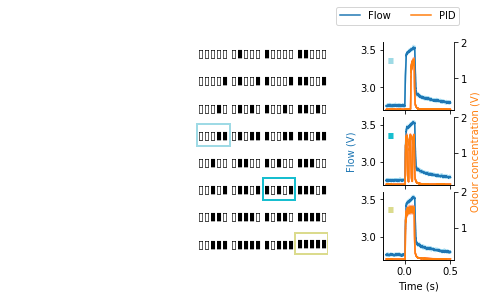

In [18]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(1, 1)
def make_schematic_plots(fig, gs, odour_legend_bbox =(1.15, 1.6), box_width=1.05):
    odour_colors = [matplotlib.cm.tab20.colors[-i] for i in range(1, 4)]
    #odour_colors = [matplotlib.cm.tab20.colors[-1], 'blue', 'red']
    print(odour_colors)
    sub_gs = gs.subgridspec(1, 15, wspace=3)
    ### Make A
    mouse_ax = fig.add_subplot(sub_gs[0, :6], frameon=False)
    mouse_ax.set_xticks([])
    mouse_ax.set_yticks([])
    

    ### Make part B
    blip_ax = fig.add_subplot(sub_gs[0, 6:11])
    for i in range(32):
        blip_ax.text(int(i/8)+0.1, 8-i%8-0.5, glyphs[i], fontsize=11)
        if i in odour_indexes:
            color = odour_colors[odour_indexes.index(i)]
            blip_ax.plot([int(i/8)+0.05, int(i/8)+0.05], [8-i%8-0.8, 8-i%8], color=color, linewidth=2)
            blip_ax.plot([int(i/8)+box_width, int(i/8)+box_width], [8-i%8-0.8, 8-i%8], color=color, linewidth=2)
            blip_ax.plot([int(i/8)+0.05, int(i/8)+box_width], [8-i%8-0.8, 8-i%8-0.8], color=color, linewidth=2)
            blip_ax.plot([int(i/8)+0.05, int(i/8)+box_width], [8-i%8, 8-i%8], color=color, linewidth=2)
    blip_ax.set_xlim(0, 4.05)
    blip_ax.set_ylim(0, 8)
    blip_ax.axis('off')

    ### Make part C
    odour_axes = sub_gs[0, 12:15].subgridspec(ncols=1, nrows=3, hspace=0.1)

    odour_ax1 = fig.add_subplot(odour_axes[0])
    odour_ax2 = fig.add_subplot(odour_axes[1], sharex=odour_ax1, sharey=odour_ax1)
    odour_ax3 = fig.add_subplot(odour_axes[2], sharex=odour_ax1, sharey=odour_ax1)

    plt.setp(odour_ax1.get_xticklabels(), visible=False)
    plt.setp(odour_ax2.get_xticklabels(), visible=False)

    odour_ax1 = plot_pid_and_flow(3, odour_ax1, legend=True, bb_legend=odour_legend_bbox)
    odour_ax2 = plot_pid_and_flow(21, odour_ax2, y_axis=True)
    odour_ax3 = plot_pid_and_flow(31, odour_ax3)
    odour_ax3.set_xlabel('Time (s)')

    for index, ax in enumerate([odour_ax1, odour_ax2, odour_ax3]):
        ax.annotate('.', xy=(0.1, 0.5), xycoords='axes fraction', xytext=(0, 3),
                textcoords='offset points', ha='center',
                va='bottom', fontsize=50, color=odour_colors[index])

    return mouse_ax, blip_ax, odour_ax1, odour_ax2, odour_ax3
make_schematic_plots(fig, gs[0])

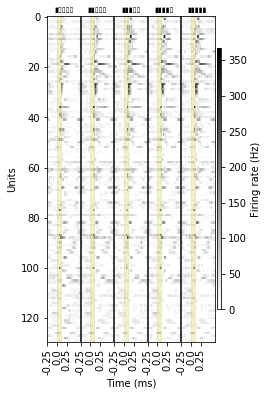

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
mean_summed_usrt1 = np.sum(mean_usrt1[:, :, 50:], axis=-1)
#joined_psths = mean_usrt1[:, conc_trials[::-1], 25:].reshape(130, -1)
z_scored_mean_usrt1 = (mean_usrt1 - np.mean(mean_usrt1[:, :, :50], axis=-1)[:, :, None]) / np.std(mean_usrt1[:, :, :50], axis=-1)[:, :, None]

#link = linkage(joined_psths, metric='euclidean')
#dend = dendrogram(link, no_plot=True)
conc_corrs = [np.corrcoef(i[conc_trials[::-1]], range(5))[0, 1] for i in mean_summed_usrt1]
sorted_conc_corrs = np.argsort(conc_corrs)
onset_corrs = [np.corrcoef(i[onset_trials], range(5))[0, 1] for i in mean_summed_usrt1]
sorted_onset_corrs = np.argsort(onset_corrs)

normed_mean_usrt = mean_usrt1 / np.max(mean_usrt1, axis=0)[None, :, :]
plot_heatmap(ax, mean_usrt1, conc_trials, sorted_conc_corrs[::-1], normalise_rows=False, time_ticks_base=[-0.25, 0, 0.25])

In [26]:
pearsons = [scipy.stats.pearsonr(i[conc_trials[::-1]], range(5)) for i in mean_summed_usrt1]

In [32]:
pearsons_conc = [scipy.stats.pearsonr(i[conc_trials[::-1]], range(5)) for i in mean_summed_usrt1]
pearsons_onset = [scipy.stats.pearsonr(i[onset_trials[::-1]], range(5)) for i in mean_summed_usrt1]
c_count = 0
o_count = 0
for i, j in zip(np.array(pearsons_conc), np.array(pearsons_onset)):
    if i[1] < 0.05:
        c_count += 1
    if j[1] < 0.05:
        o_count += 1
print(c_count, o_count)

19 35


In [133]:
print(np.where(sorted_conc_corrs)

[ 68  18 101  11  76  17  88  23  21  44  31  94  43 109  41  96  78 115
  73 119  93  85 121  74  28  25  61 128  26 103  56  92  95  98   5  13
  24   2  22   8  27  35 105 100  84  10 117  42  82  19  67 126  72   1
   9   3  14  71 107  90 114   4  12  89   0  46  48  79  65  38  16  32
  87 116 102  77 118  15  97  80  75  30  45  69 104  53   6  83  86  54
  99  66 106  40 111  57  33  49  36  37  81  39  91  64  34  51  47  70
 113   7  29 125 108  20 120 129  55 110 112  50  63 123  60  59  62 124
  52  58 122 127]


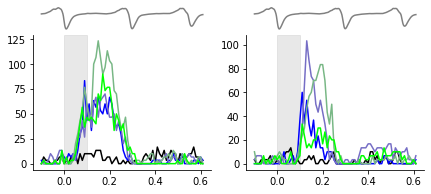

In [116]:
fig = plt.figure(figsize=(7, 3))
gs = fig.add_gridspec(1, 2)
ui = 4
plot_cell_psth(mean_usrt1, iti_uis[ui], iti_trials, gs[0, 0], cmap1)
plot_cell_psth(mean_usrt2, iti_uis[ui], iti_trials, gs[0, 1], cmap1)

[(0.6196078431372549, 0.8549019607843137, 0.8980392156862745), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), (0.8588235294117647, 0.8588235294117647, 0.5529411764705883)]


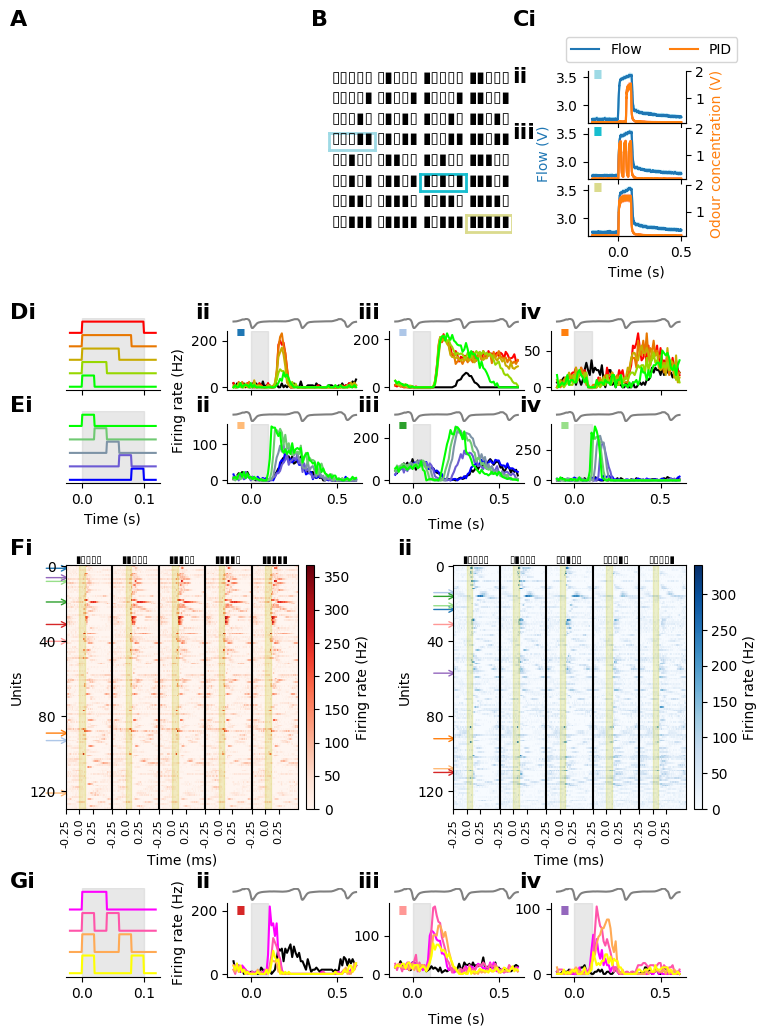

In [28]:
fig = plt.figure(figsize=(8, 12), dpi=100)
gs = fig.add_gridspec(4, 1, hspace=0.5)
mouse_ax, blip_ax, odour_ax1, odour_ax2, odour_ax3 = make_schematic_plots(fig, gs[0, 0], odour_legend_bbox=(1.6, 1.8))


sub_gs = gs[1].subgridspec(2, 4, hspace=0.3)
cuis = [15, 1, 4]
conc_inst_ax = plot_valve_instruc(sub_gs[0, 0], plots_conc, cmap2, xticklabels=False, ax_compress=0.7)
cax11, rax11 = plot_cell_psth(mean_usrt1, conc_uis[cuis[0]], conc_trials, sub_gs[0, 1], cmap2, xticklabels=False)
cax12, rax12 = plot_cell_psth(mean_usrt2, conc_uis[cuis[1]], conc_trials, sub_gs[0, 2], cmap2, xticklabels=False)
cax13, rax13 = plot_cell_psth(mean_usrt2, conc_uis[cuis[2]], conc_trials, sub_gs[0, 3], cmap2, xticklabels=False)
ouis = [2, 8, 35]
onset_inst_ax = plot_valve_instruc(sub_gs[1, 0], plots_onset[::-1], matplotlib.colors.ListedColormap(cmap1.colors[::-1]), ax_compress=0.7)
cax21, rax21 = plot_cell_psth(mean_usrt2, onset_uis[ouis[0]], onset_trials, sub_gs[1, 1], cmap1)
cax22, rax22 = plot_cell_psth(mean_usrt1, onset_uis[ouis[1]], onset_trials, sub_gs[1, 2], cmap1)
cax23, rax23 = plot_cell_psth(mean_usrt2, onset_uis[ouis[2]], onset_trials, sub_gs[1, 3], cmap1)
overlay_ax = fig.add_subplot(sub_gs[:, 1:], frameon=False)
overlay_ax.set_xticks([]), overlay_ax.set_yticks([])
overlay_ax.set_ylabel('Firing rate (Hz)', labelpad=30)
overlay_ax.set_xlabel('Time (s)', labelpad=25)
onset_inst_ax.set_xlabel('Time (s)')




sub_gs = gs[2:].subgridspec(4, 4, wspace=4)
#sub_sub_gs = sub_gs[:3, :].subgridspec(1, 2, wspace=0.7)
heatmap_ax1 = fig.add_subplot(sub_gs[:3, :2])
cbar_ax1 = plot_heatmap(heatmap_ax1, mean_usrt1, conc_trials, sorted_conc_corrs[::-1], normalise_rows=False, cmap='Reds', time_ticks_base=[-0.25, 0, 0.25])
heatmap_ax2 = fig.add_subplot(sub_gs[:3, 2:])
cbar_ax2 = plot_heatmap(heatmap_ax2, mean_usrt1, onset_trials, sorted_onset_corrs[::-1], normalise_rows=False, cmap='Blues', time_ticks_base=[-0.25, 0, 0.25])
hm_ax1_pos = heatmap_ax1.get_position()
hm_ax2_pos = heatmap_ax2.get_position()
scale = 0.8
hm_ax1_pos_y0 = hm_ax1_pos.y0 + (hm_ax1_pos.height * (1 - scale))
hm_ax1_pos_height = hm_ax1_pos.height * scale
heatmap_ax1.set_position([hm_ax1_pos.x0, hm_ax1_pos_y0, hm_ax1_pos.width, hm_ax1_pos_height])
cbar_ax1_pos = cbar_ax1.get_position()
cbar_ax1.set_position([cbar_ax1_pos.x0, hm_ax1_pos_y0, cbar_ax1_pos.width*0.5, hm_ax1_pos_height])

hm_ax2_pos_y0 = hm_ax2_pos.y0 + (hm_ax2_pos.height * (1 - scale))
hm_ax2_pos_height = hm_ax2_pos.height * scale
heatmap_ax2.set_position([hm_ax2_pos.x0, hm_ax2_pos_y0, hm_ax2_pos.width, hm_ax2_pos_height])
cbar_ax2_pos = cbar_ax2.get_position()
cbar_ax2.set_position([cbar_ax2_pos.x0, hm_ax2_pos_y0, cbar_ax2_pos.width*0.5, hm_ax2_pos_height])

heatmap_ax1.set_yticks(np.arange(0, 130, 40))
heatmap_ax2.set_yticks(np.arange(0, 130, 40))
heatmap_ax1.set_ylim(129.5, -0.5)
heatmap_ax2.set_ylim(129.5, -0.5)

sub_sub_gs = sub_gs[-1, :].subgridspec(1, 4)

iuis = [1, 3, 4]
iti_inst_ax = plot_valve_instruc(sub_sub_gs[0], plots_iti, matplotlib.cm.spring, xticklabels=True, ax_compress=0.7)
cax31, rax31 = plot_cell_psth(mean_usrt1, iti_uis[iuis[0]], iti_trials, sub_sub_gs[1], matplotlib.cm.spring)
cax32, rax32 = plot_cell_psth(mean_usrt2, iti_uis[iuis[1]], iti_trials, sub_sub_gs[2], matplotlib.cm.spring)
cax33, rax33 = plot_cell_psth(mean_usrt2, iti_uis[iuis[2]], iti_trials, sub_sub_gs[3], matplotlib.cm.spring)
overlay_ax = fig.add_subplot(sub_sub_gs[1:], frameon=False)
overlay_ax.set_xticks([]), overlay_ax.set_yticks([])
overlay_ax.set_ylabel('Firing rate (Hz)', labelpad=30)
overlay_ax.set_xlabel('Time (s)', labelpad=25)
onset_inst_ax.set_xlabel('Time (s)')

conc_locs = []
onset_locs = []
for uis, subset_uis in zip([cuis, ouis, iuis], [conc_uis, onset_uis, iti_uis]):
    for i in uis:
        conc_loc = np.where(sorted_conc_corrs[::-1] == subset_uis[i])[0][0]
        onset_loc = np.where(sorted_onset_corrs[::-1] == subset_uis[i])[0][0]
        conc_locs.append(conc_loc)
        onset_locs.append(onset_loc)

# for index, ax in enumerate([rax11, rax12, rax13, rax21, rax22, rax23, rax31, rax32, rax33]):
#     ax.set_title(f'TO index: {conc_locs[index]}; L index: {onset_locs[index]}', fontsize=8)

axes = [mouse_ax, blip_ax, odour_ax1, odour_ax2, odour_ax3, conc_inst_ax, rax11, rax12, rax13,
        onset_inst_ax, rax21, rax22, rax23, heatmap_ax1, heatmap_ax2, iti_inst_ax, rax31, rax32, rax33]
axes_labels = ['A', 'B', 'Ci', 'ii', 'iii', 'Di', 'ii', 'iii', 'iv', 'Ei', 'ii', 'iii', 'iv', 'Fi', 'ii', 'Gi', 'ii', 'iii', 'iv']
align_x = [[0, 5, 9, 13, 15], [2, 3, 4], [6, 10, 16], [7, 11, 17], [8, 12, 18]]
align_y = [[0, 1, 2], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14], [15, 16, 17, 18]]
dx = [0, -0.02, -0.03, -0.03, -0.03, 0, -0.04, -0.04, -0.04, 0, -0.04, -0.04, -0.04, 0, 0, 0, -0.04, -0.04, -0.04]
dy = [0, 0, 0,0, 0, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, 0, 0, -0.00, -0.00, -0.00, -0.00]
label_axes.label_axes(axes,axes_labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dx=dx, dy=dy)

heatmap_ax1.tick_params(axis='x', labelsize=8)
heatmap_ax2.tick_params(axis='x', labelsize=8)

annotated_colors = matplotlib.cm.tab20.colors
for ci, oi in zip(conc_locs, onset_locs):
    heatmap_ax1.annotate('', xy=(10, ci), xycoords='data',
            xytext=(-20, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color=annotated_colors[conc_locs.index(ci)]), zorder=-10)
    heatmap_ax2.annotate('', xy=(10, oi), xycoords='data',
            xytext=(-20, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color=annotated_colors[onset_locs.index(oi)]), zorder=-10)
for index, ax in enumerate([cax11, cax12, cax13, cax21, cax22, cax23, cax31, cax32, cax33]):
    ax.annotate('.', xy=(0.1, 0.6), xycoords='axes fraction', xytext=(0, 3),
            textcoords='offset points', ha='center',
            va='bottom', fontsize=50, color=annotated_colors[index])
plt.savefig('230908_Fig1.pdf', bbox_inches='tight')

In [28]:
print([conc_uis[i] for i in cuis])
print([onset_uis[i] for i in ouis])
print([iti_uis[i] for i in iuis])

[122, 24, 27]
[21, 29, 123]
[36, 54, 59]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9e3abde278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e390f2b38>)

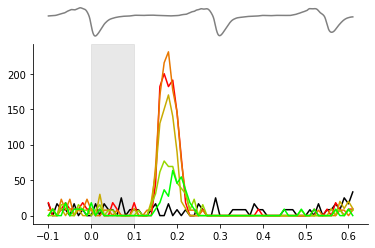

In [42]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
plot_cell_psth(mean_usrt1, sorted_conc_corrs[-2], conc_trials, gs[0], cmap=cmap2)

In [26]:
print(np.where(sorted_conc_corrs == conc_uis[2]))

(array([25]),)


In [531]:
print(mean_usrt1.shape)

(130, 32, 112)


In [523]:
print(onset_trials, conc_trials)

[1, 2, 4, 8, 16] [31, 30, 28, 24, 16]


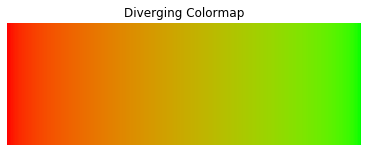

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import colorspacious as cs

def create_diverging_colormap(color1, color2, n=256):
    # Convert the two endpoint colors to LAB color space
    lab1 = cs.cspace_convert(color1, start="sRGB1", end="CIELab")
    lab2 = cs.cspace_convert(color2, start="sRGB1", end="CIELab")
    
    # Interpolate between the two LAB colors
    lab_interp = np.array([np.linspace(start, end, n) for start, end in zip(lab1, lab2)]).T

    # Convert interpolated LAB colors back to RGB
    rgb_interp = np.array([cs.cspace_convert(color, start="CIELab", end="sRGB1") for color in lab_interp])
    
    # Clip values to be within [0, 1], due to minor computational discrepancies
    rgb_interp = np.clip(rgb_interp, 0, 1)

    return rgb_interp

# Define your colors in sRGB
blue = [0, 0, 1]
red = [1, 0, 0]
green = [0, 1, 0]

colormap_data = create_diverging_colormap(blue, green)

# Create the colormap
cmap1 = matplotlib.colors.ListedColormap(colormap_data)

colormap_data = create_diverging_colormap(red, green)
cmap2 = matplotlib.colors.ListedColormap(colormap_data)

# Display the colormap
fig, ax = plt.subplots(figsize=(5, 2), constrained_layout=True)
colormap_display = np.linspace(0, 1, 256).reshape(1, -1)
colormap_display = np.vstack((colormap_display, colormap_display))
ax.imshow(colormap_display, aspect='auto', cmap=cmap2)
ax.set_title('Diverging Colormap')
ax.axis('off')
plt.show()


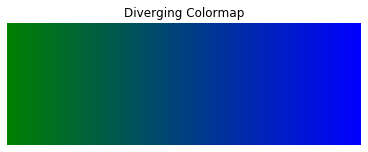

In [16]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "blue"])
fig, ax = plt.subplots(figsize=(5, 2), constrained_layout=True)
colormap_display = np.linspace(0, 1, 256).reshape(1, -1)
colormap_display = np.vstack((colormap_display, colormap_display))
ax.imshow(colormap_display, aspect='auto', cmap=cmap)
ax.set_title('Diverging Colormap')
ax.axis('off')
plt.show()

In [ ]:
plt.plot()

In [500]:
cs.cspace_convert((0, 1, 0), 'sRGB', 'CIELab')

ValueError: No path found from {'name': 'sRGB'} -> {'name': 'CIELab', 'XYZ100_w': array([ 95.047, 100.   , 108.883])}